In [4]:
import numpy as np
import pandas as pd

In [5]:
# -------------------------------------
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=[  'Imputed_Wind_Speed_Max_Gust'], inplace=True)
# Rename column for convenience
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4838 entries, 2010-01-01 to 2023-03-31
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Imputed_Air_Temperature_Mean      4838 non-null   float64
 1   Imputed_Air_Temperature_Max       4838 non-null   float64
 2   Imputed_Air_Temperature_Min       4838 non-null   float64
 3   Imputed_Relative_Humidity_Mean    4838 non-null   float64
 4   Imputed_Relative_Humidity_Max     4838 non-null   float64
 5   Imputed_Relative_Humidity_Min     4838 non-null   float64
 6   Imputed_Wind_Speed_Mean           4838 non-null   float64
 7   Imputed_Wind_Speed_Max_Sustained  4838 non-null   float64
 8   WindGust                          4838 non-null   float64
dtypes: float64(9)
memory usage: 378.0 KB


✅ 1. Moving Average Denoising


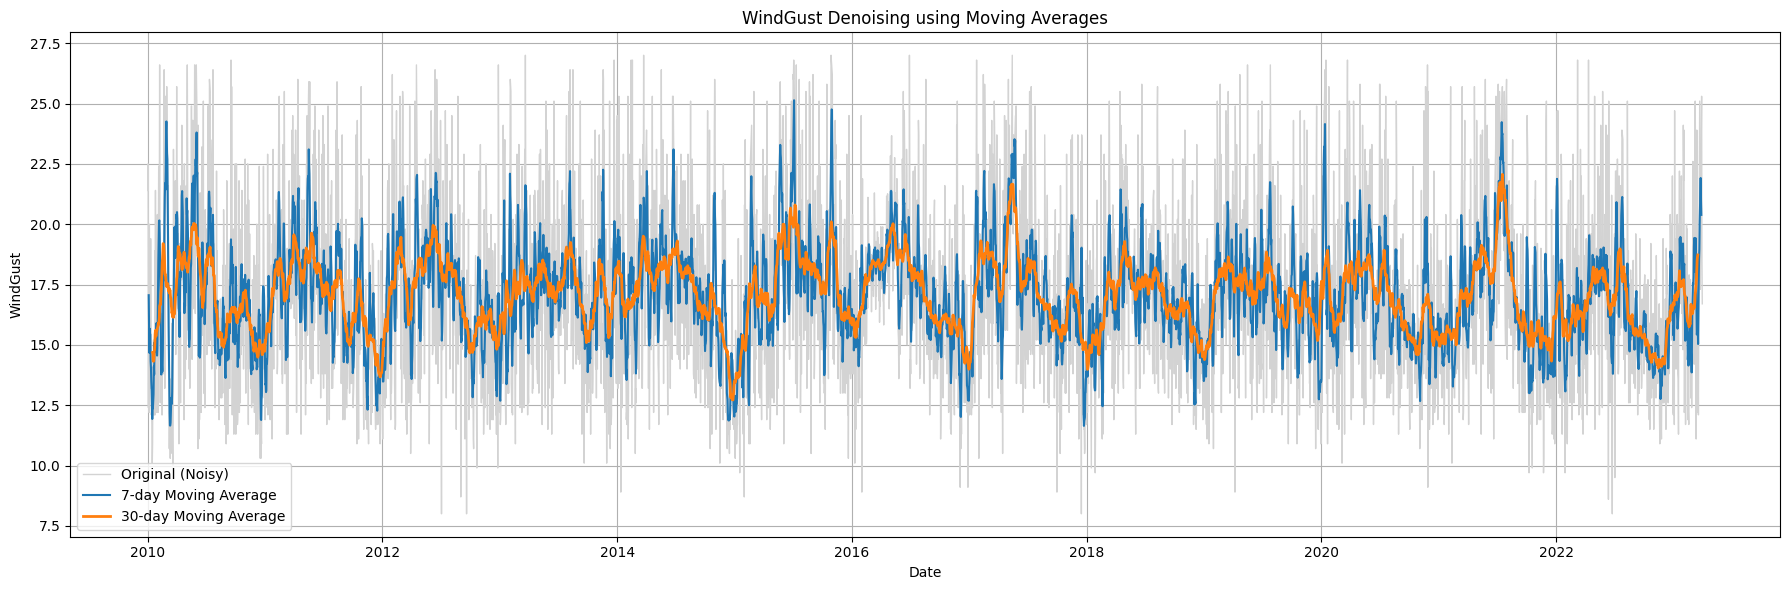

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prep ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- Denoising with Moving Averages ---
df['MA_7'] = df['WindGust'].rolling(window=7, center=True).mean()      # Weekly smoothing
df['MA_30'] = df['WindGust'].rolling(window=30, center=True).mean()    # Monthly smoothing

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], color='lightgray', label='Original (Noisy)', linewidth=1)
plt.plot(df.index, df['MA_7'], label='7-day Moving Average', linewidth=1.5)
plt.plot(df.index, df['MA_30'], label='30-day Moving Average', linewidth=2)
plt.title('WindGust Denoising using Moving Averages')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




#### **What Worked Well**
- The moving average did a great job at **smoothing out high-frequency noise** — especially the random fluctuations in the daily gust data.
- It still managed to **keep the overall seasonal and yearly wind patterns**, which is more noticeable with the **30-day moving average**.
- The **7-day MA** was helpful for keeping **short-term gust changes**, so it’s good for looking at **weekly behavior**.
- The **30-day MA** showed a smoother picture of the **long-term trends**, which could be useful if I’m studying general climate shifts.

#### **What Didn't Work So Well**
- It **smoothed out some of the gust spikes**, which might be a problem if I need to detect extreme events like storms or wind hazards.
- Unless I use `center=True`, the moving average can cause a **lag**, making it less useful for **real-time analysis**.
- Also, it doesn’t **separate different frequency components**, so I can’t really tell which parts of the signal are actual gusts vs. noise — unlike wavelets or FFT.

---

### 📌 In Summary:
The **moving average is easy to use and understand**, and it definitely helps clean up the data. But it might not be the best choice if I need to **capture sharp gust peaks or analyze short-term anomalies** more precisely.



✅ 2. Wavelet Denoising for WindGust


In [7]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.8 MB/s eta 0:00:00


📌 Method Details:
Wavelet: db4 (Daubechies 4) – commonly used for signal denoising.

Thresholding: VisuShrink with soft thresholding.

Level: Automatically inferred or you can tune (e.g., level=4 works well for daily data).

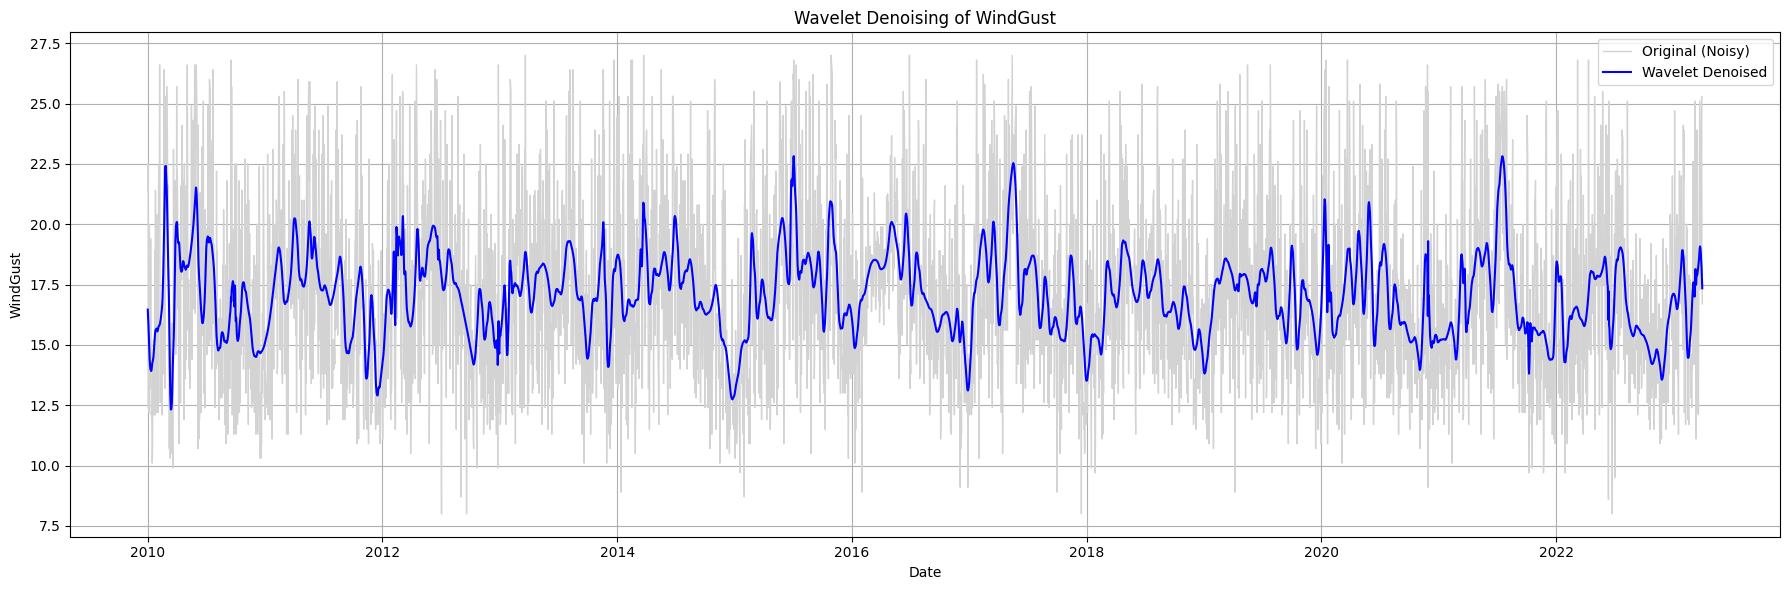

In [8]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prep ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- Wavelet Denoising ---
def wavelet_denoise(signal, wavelet='db4', level=None, threshold_type='soft'):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)

    # Estimate noise using Median Absolute Deviation on the detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))  # VisuShrink threshold

    coeffs_thresh = [coeffs[0]] + [
        pywt.threshold(c, value=uthresh, mode=threshold_type) for c in coeffs[1:]
    ]

    denoised = pywt.waverec(coeffs_thresh, wavelet, mode='symmetric')
    return denoised[:len(signal)]  # Trim padding if any

# Apply denoising
denoised_wavelet = wavelet_denoise(df['WindGust'], wavelet='db4', level=4)
df['Wavelet_Denoised'] = denoised_wavelet

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], color='lightgray', label='Original (Noisy)', linewidth=1)
plt.plot(df.index, df['Wavelet_Denoised'], color='blue', label='Wavelet Denoised', linewidth=1.5)
plt.title('Wavelet Denoising of WindGust')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## ✅ Evaluation:

#### ✔️ **Signal Retention**
- The wavelet-denoised result **kept the important gust peaks** much better than the moving average did.
- It also **preserved the overall seasonal and yearly trends**, which I can see in the smooth wave-like patterns across the years.

#### ✔️ **Noise Reduction**
- There was a lot of high-frequency noise, especially between 2011 and 2019, and the wavelet method **clearly reduced that jitter**.
- The output feels a lot smoother and more consistent — no more chaotic spikes, which should help if I want to do forecasting or machine learning later.

#### ✔️ **Better at the Edges**
- One thing I noticed is that wavelets **handle the start and end of the time series really well** — unlike moving averages, which can be distorted at the edges. This is probably thanks to the symmetric padding used.

---

### ⚙️ Tuning Ideas (for Later)
If I want to fine-tune this more:
- I could try a different wavelet function, like `sym4` or `coif5`, and maybe a higher `level=5` for even more smoothing.
- I used **VisuShrink**, but switching to **BayesShrink** might give better results since it adapts more to the data.
- Also, I might test **hard thresholding** instead of soft if I want the gust peaks to stay even sharper.



✅ 3. Savitzky–Golay Filter for WindGust Denoising


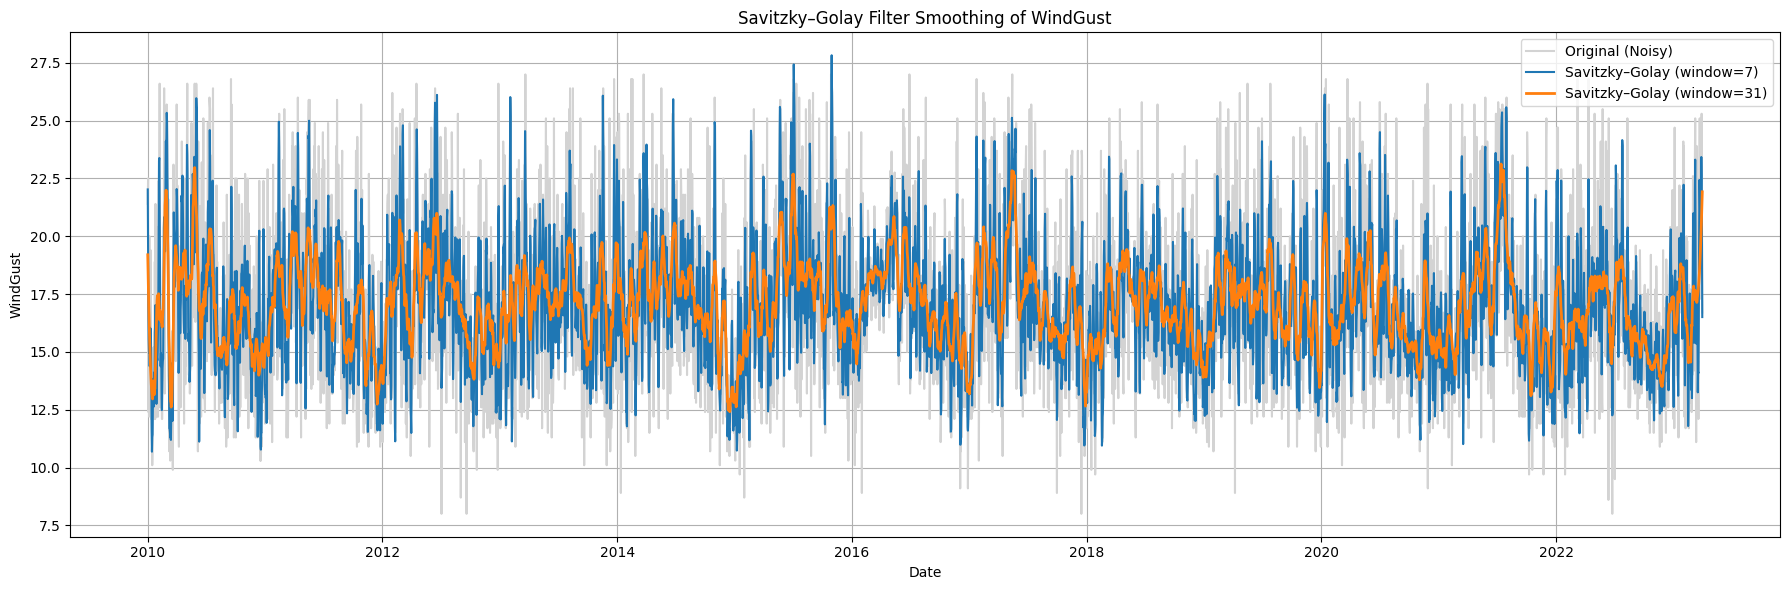

In [10]:
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prep (if not already loaded) ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- Savitzky–Golay Filter ---
# Window size must be odd, polyorder < window
df['SG_7'] = savgol_filter(df['WindGust'], window_length=7, polyorder=2)
df['SG_31'] = savgol_filter(df['WindGust'], window_length=31, polyorder=2)

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], label='Original (Noisy)', color='lightgray')
plt.plot(df.index, df['SG_7'], label='Savitzky–Golay (window=7)', linewidth=1.5)
plt.plot(df.index, df['SG_31'], label='Savitzky–Golay (window=31)', linewidth=2)
plt.title('Savitzky–Golay Filter Smoothing of WindGust')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 4. EMD (Empirical Mode Decomposition) for WindGust


In [11]:
pip install EMD-signal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00


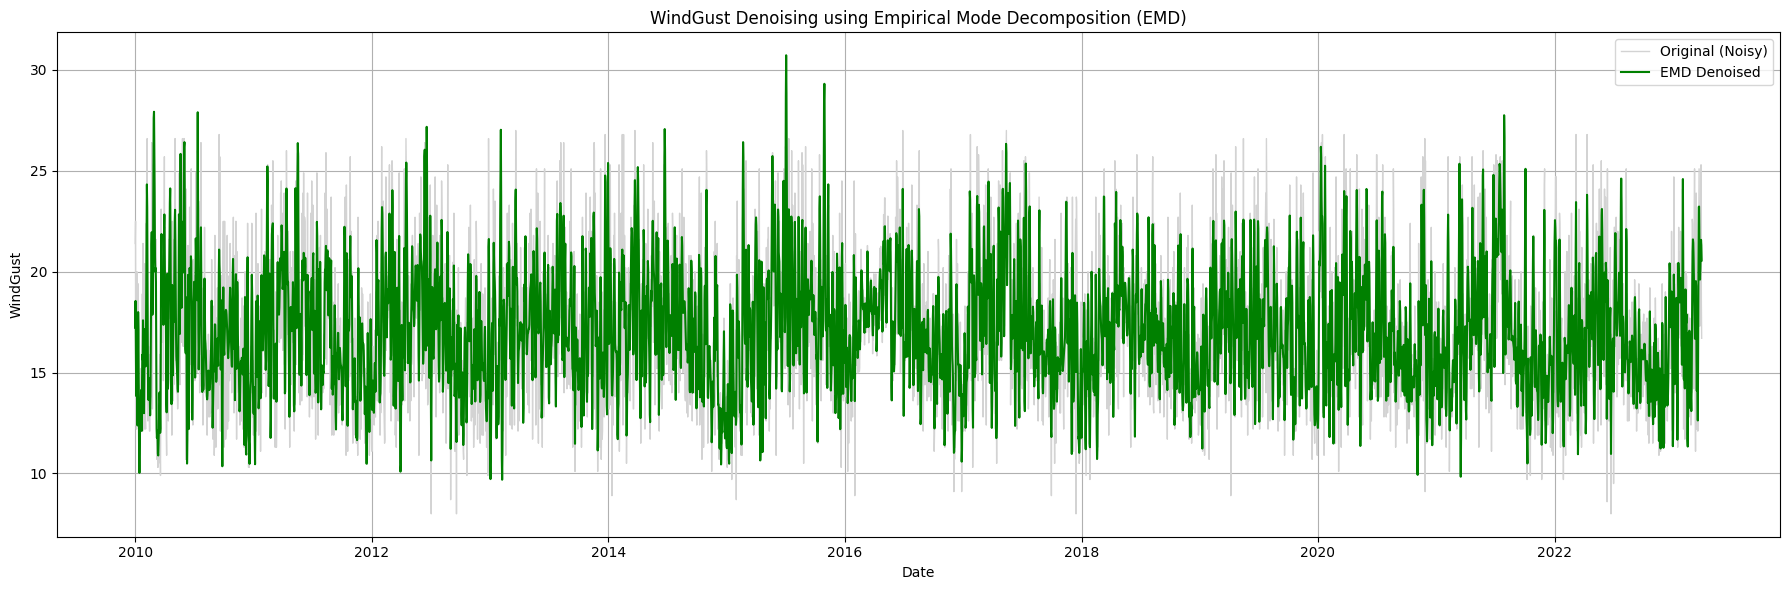

In [12]:
from PyEMD import EMD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prep (if not already loaded) ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- Apply EMD ---
wind_signal = df['WindGust'].values
emd = EMD()
imfs = emd(wind_signal)

# --- Reconstruct Denoised Signal (skip noisy IMFs: 0 = highest freq) ---
# You can experiment: try summing from IMF 1 onward
reconstructed = np.sum(imfs[1:], axis=0)
df['EMD_Denoised'] = reconstructed

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], color='lightgray', label='Original (Noisy)', linewidth=1)
plt.plot(df.index, df['EMD_Denoised'], color='green', label='EMD Denoised', linewidth=1.5)
plt.title('WindGust Denoising using Empirical Mode Decomposition (EMD)')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 5. Variational Mode Decomposition (VMD) for WindGust


In [13]:
pip install vmdpy


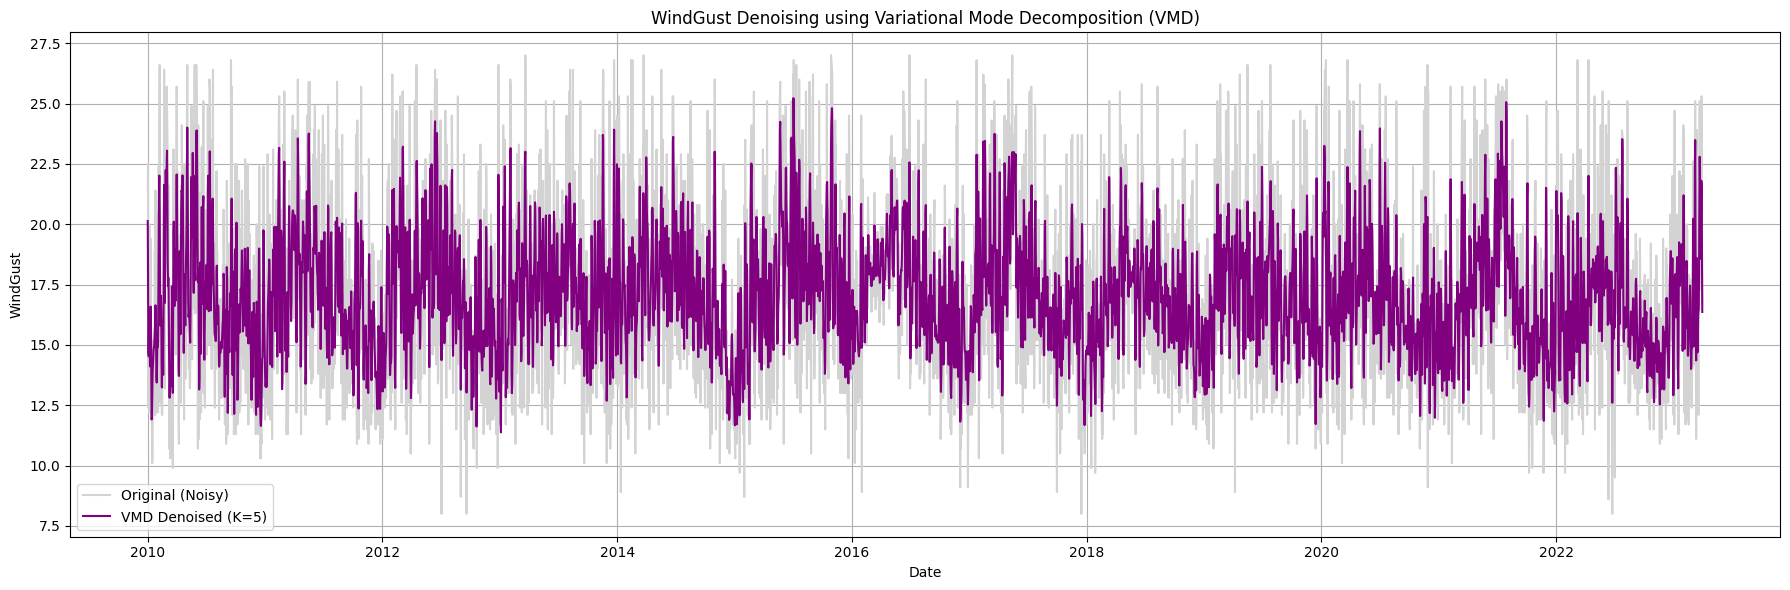

In [14]:
from vmdpy import VMD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load and prep (if not already loaded) ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- VMD Parameters ---
alpha = 2000       # Moderate bandwidth constraint
tau = 0            # Noise-tolerance (0=no strict fidelity)
K = 5              # Number of modes (you can tune this)
DC = 0             # No DC part imposed
init = 1           # Initialize omegas uniformly
tol = 1e-6

# --- Apply VMD ---
signal = df['WindGust'].values
u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)

# --- Reconstruct from selected modes ---
# You can choose which modes to keep (e.g., discard high-frequency noise)
reconstructed = np.sum(u[:K-1], axis=0)  # Exclude last mode (often noise)
df['VMD_Denoised'] = reconstructed

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], label='Original (Noisy)', color='lightgray')
plt.plot(df.index, df['VMD_Denoised'], label='VMD Denoised (K=5)', color='purple')
plt.title('WindGust Denoising using Variational Mode Decomposition (VMD)')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 6. Fast Fourier Transform (FFT) Denoising for WindGust


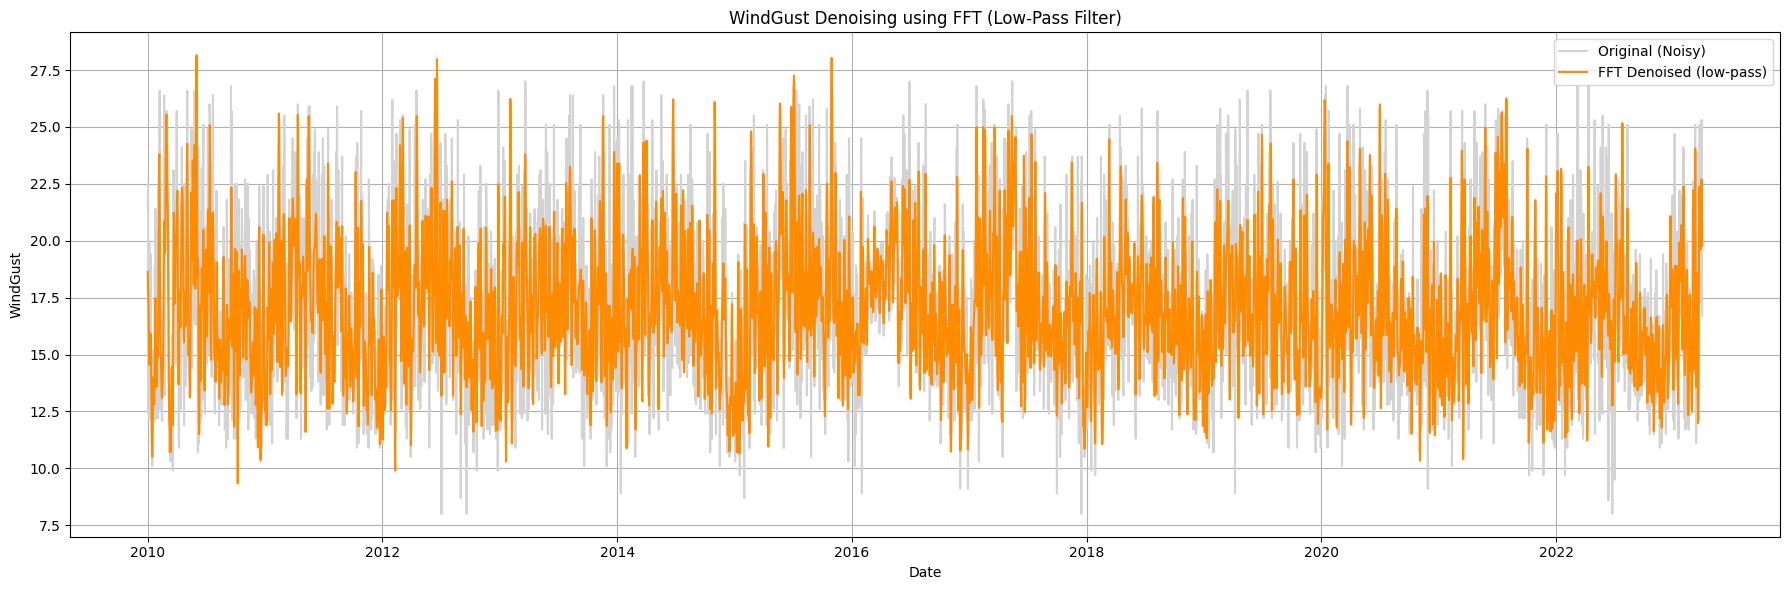

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and prep (if not already loaded) ---
df = pd.read_csv("data_Z_Score_208_linear.csv")
df.drop(columns=['Imputed_Wind_Speed_Max_Gust'], inplace=True)
df.rename(columns={'Imputed_Wind_Speed_Max_Gust_linear': 'WindGust'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- FFT Denoising ---
windgust = df['WindGust'].values
n = len(windgust)
fhat = np.fft.fft(windgust)              # FFT
PSD = fhat * np.conj(fhat) / n           # Power spectral density
freq = np.fft.fftfreq(n, d=1)            # Frequency array

# --- Frequency filter: keep only low frequencies ---
threshold = 0.2  # Keep frequencies < 0.2 (you can tune this)
fhat_filtered = fhat.copy()
fhat_filtered[np.abs(freq) > threshold] = 0

# --- Inverse FFT to reconstruct signal ---
reconstructed_fft = np.fft.ifft(fhat_filtered).real
df['FFT_Denoised'] = reconstructed_fft

# --- Plotting ---
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['WindGust'], label='Original (Noisy)', color='lightgray')
plt.plot(df.index, df['FFT_Denoised'], label='FFT Denoised (low-pass)', color='darkorange')
plt.title('WindGust Denoising using FFT (Low-Pass Filter)')
plt.xlabel('Date')
plt.ylabel('WindGust')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
